## Gait Analysis on  WISDM Dataset

###  ML Model

In [1]:
##model_wisdm.py
import numpy as np
import pandas as pd
#import seaborn as sns

#preprocess data 
def preprocess(data):
    #column_names = ['user_id','activity','timestamp', 'x_axis', 'y_axis', 'z_axis']
    df = pd.read_csv(data,on_bad_lines='skip',index_col=False)
    df.columns= ['user_id','activity','timestamp', 'x_axis', 'y_axis', 'z_axis']
    df = df.dropna() # removing null values
    df['z_axis'].replace(regex=True, inplace=True, to_replace=r';', value=r'') # Transforming the z-axis to float
    
    #### Label encoding 
    from sklearn.preprocessing import LabelEncoder
    label = LabelEncoder()
    df['label'] = label.fit_transform(df['activity'])
    
    ##Balanace this Data :Under sampling
    Walking = df[df['activity']=='Walking'].head(48394).copy()
    Jogging = df[df['activity']=='Jogging'].head(48394).copy()
    Upstairs = df[df['activity']=='Upstairs'].head(48394).copy()
    Downstairs = df[df['activity']=='Downstairs'].head(48394).copy()
    Sitting = df[df['activity']=='Sitting'].head(48394).copy()
    Standing = df[df['activity']=='Standing'].copy()
    
    #df_balanced = pd.DataFrame()
    df_balanced = pd.concat([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
    
    ##Normalize/Standardized data
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    X = df_balanced[['x_axis', 'y_axis', 'z_axis']]
    target = df_balanced['label']
    scaler = StandardScaler()
    dx = scaler.fit_transform(X)
    df_scaled = pd.DataFrame(data = dx, columns = X.columns)
    df_scaled['label'] = target.values
    return df_scaled

In [2]:
dff=preprocess('C:/Datasets/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')
#dff.head()

C:\Users\adanent\Anaconda3\envs\Annotation_tool\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
## Segmenting samples (windowing) functions 
import scipy.stats as stats
Fs = 20
segment_size =  500# Fs*4 # window size=n_time steps=frame size
step_size =  25 # Fs*2  # step size 
n_features = 3     

def get_segments(df, segment_size, step_size):
    segments = []
    labels = []
    for i in range(0, len(df) - segment_size - 1, step_size):
        xs = dff['x_axis'].values[i: i + segment_size]
        ys = dff['y_axis'].values[i: i + segment_size]
        zs = dff['z_axis'].values[i: i + segment_size]
        label = stats.mode(dff['label'][i: i + segment_size])[0][0] # [0][0] shows the index of the current sequence
        #We used the dstack() to ensure that each array is stacked in such a way that
        #the features are separated in the third dimension, as we would prefer.
        segments.append(np.dstack([xs, ys, zs]))
        labels.append(label)

    # Bring the segments into a better shape
    segments=np.asarray(segments, dtype= np.float32).reshape(-1, segment_size, n_features)
    labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)
                
    return segments, labels

In [4]:
X, y = get_segments(dff, segment_size, step_size)

In [5]:
X.shape, y.shape

((11595, 500, 3), (11595, 6))

### CNN-GRU

In [6]:
# reshape data into time steps of sub-sequences
n_steps, n_length = 10, 50
df_X = X.reshape((X.shape[0], n_steps, n_length, n_features))
n_outputs = y.shape[1] #n_outputs= 6

In [7]:
df_X.shape

(11595, 10, 50, 3)

In [8]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM,GRU
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [9]:
#from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split

In [10]:
# split data into training set and test set
X_train_main, X_test, y_train_main, y_test = train_test_split(df_X, y,test_size=0.20, random_state=7)

# split training set into training and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_main,y_train_main,test_size=0.30,random_state=7)

In [11]:
X_train.shape, X_test.shape,y_train.shape,y_test.shape

((6493, 10, 50, 3), (2319, 10, 50, 3), (6493, 6), (2319, 6))

In [12]:
def create_model(optimizer= 'rmsprop' , init= 'glorot_uniform' ):
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=32, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Dropout(0.08)))
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(64 , return_sequences= True ))
    model.add(GRU(64))
    model.add(Dropout(0.1))
    model.add(Dense(y_train.shape[1], activation = 'softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [13]:
### Initialize Model
cnn_gru_model=create_model()

In [14]:
history = cnn_gru_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=50)

Epoch 1/10
130/130 [==============================] - 34s 133ms/step - loss: 0.5044 - accuracy: 0.8004 - val_loss: 0.1546 - val_accuracy: 0.9429
Epoch 2/10
130/130 [==============================] - 14s 107ms/step - loss: 0.0789 - accuracy: 0.9734 - val_loss: 0.0351 - val_accuracy: 0.9881
Epoch 3/10
130/130 [==============================] - 15s 114ms/step - loss: 0.0227 - accuracy: 0.9940 - val_loss: 0.0210 - val_accuracy: 0.9950
Epoch 4/10
130/130 [==============================] - 15s 116ms/step - loss: 0.0099 - accuracy: 0.9983 - val_loss: 0.0167 - val_accuracy: 0.9957
Epoch 5/10
130/130 [==============================] - 12s 93ms/step - loss: 0.0569 - accuracy: 0.9835 - val_loss: 0.0082 - val_accuracy: 0.9978
Epoch 6/10
130/130 [==============================] - 10s 80ms/step - loss: 0.0086 - accuracy: 0.9977 - val_loss: 0.0139 - val_accuracy: 0.9971
Epoch 7/10
130/130 [==============================] - 10s 74ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 0.0045 - val_accur

## Save Model

In [15]:
cnn_gru_model.save('cnn_gru_500.h5')

###  Evaluate Model

In [16]:
# Make Predictions on test 
y_pred_test = cnn_gru_model.predict(X_test) #class Prediction 

y_pred_test[:3], #y_probs_test[:5]

73/73 [==============================] - 5s 23ms/step


(array([[9.87887779e-06, 1.15076555e-05, 9.99906063e-01, 1.40223574e-05,
         4.77849608e-05, 1.07035166e-05],
        [1.62953916e-06, 3.94970666e-05, 1.97016561e-04, 9.99673843e-01,
         4.19868702e-05, 4.60953524e-05],
        [1.01795806e-04, 1.44166711e-06, 6.32422671e-05, 1.49805264e-05,
         9.99802053e-01, 1.64693556e-05]], dtype=float32),)

In [17]:
y_pred_test=np.argmax(y_pred_test,axis=1) 
y_true_test=np.argmax(y_test,axis=1) 

y_true_test.shape, y_pred_test.shape

((2319,), (2319,))

In [18]:
import seaborn as sns
import sklearn.metrics as skm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix,classification_report
cm=confusion_matrix(y_true_test,y_pred_test)
print(cm)
print(acc(y_true_test,y_pred_test))
print(classification_report(y_true_test,y_pred_test))

[[392   0   0   0   0   0]
 [  0 403   0   0   0   0]
 [  0   0 356   0   0   0]
 [  0   0   0 374   0   0]
 [  1   0   0   0 413   0]
 [  0   3   0   0   0 377]]
0.9982751185855973
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       392
           1       0.99      1.00      1.00       403
           2       1.00      1.00      1.00       356
           3       1.00      1.00      1.00       374
           4       1.00      1.00      1.00       414
           5       1.00      0.99      1.00       380

    accuracy                           1.00      2319
   macro avg       1.00      1.00      1.00      2319
weighted avg       1.00      1.00      1.00      2319



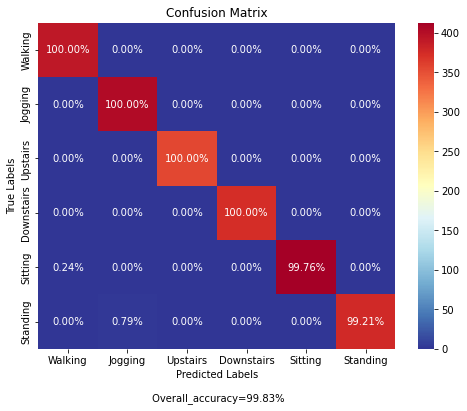

In [19]:
cf=np.empty((6,6))
for i in range(6):
    cf[i]=(cm[i]/np.sum(cm[i]))
    
# group_counts = ["{0:.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()]
labels = [f"{v1}" for v1 in group_percentages]
labels = np.asarray(labels).reshape(6,6)

fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
sns.heatmap(cm, annot=labels,fmt="",cmap='RdYlBu_r',ax=ax)
ax.set_xlabel("Predicted Labels\n\n Overall_accuracy=""{0:.2%}".format(acc(y_true_test,y_pred_test)))
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing'])
ax.yaxis.set_ticklabels(['Walking','Jogging','Upstairs','Downstairs','Sitting','Standing'])
plt.savefig('ConfusionMatrix_Ensem-HAR_WISDM',dpi=1200, bbox_inches='tight')

In [20]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_true_test, y_pred_test, average='macro')

(0.9983443846960561, 0.9982816340367827, 0.9983076051814036, None)